In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
from sklearn.model_selection import train_test_split


data = pd.read_csv("./data/AIDS_Classification.csv")
data.head(1)

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0


## Outlier cd8 vs infected

- cd80 > 2500 is mildly correlated with infected
- cd820 > 2500 is not

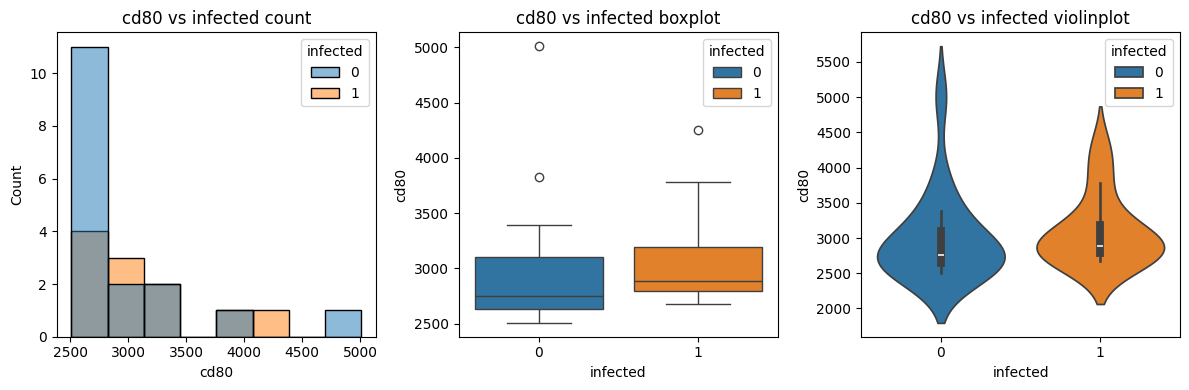

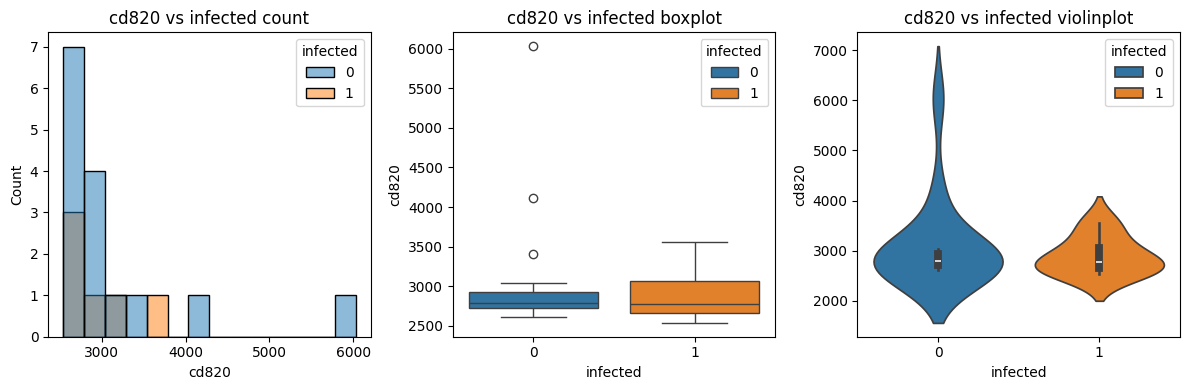

In [2]:
for variable in "cd80 cd820".split():
    fig,axes = plt.subplots(1,3,figsize = (12,4), sharey = False)

    df = data[data[variable]>2500]

    sns.histplot(data = df, x= variable, hue = "infected", ax = axes[0])
    sns.boxplot(data = df, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[1])
    sns.violinplot(data = df, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[2])


    axes[0].set_title(f'{variable} vs infected count')
    axes[1].set_title(f'{variable} vs infected boxplot')
    axes[2].set_title(f'{variable} vs infected violinplot')

    plt.tight_layout()
    plt.show()

## Symptoms vs Karnofsky score


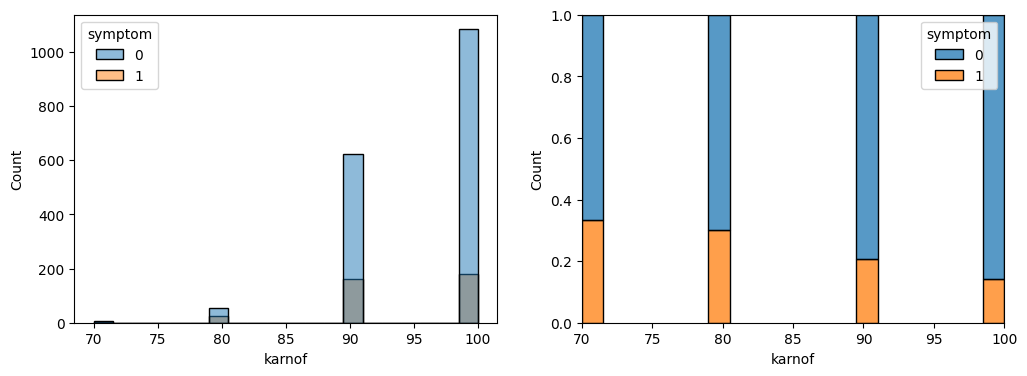

In [3]:
fig, axes = plt.subplots(1,2,figsize = (12,4), sharey=False)
df = data
sns.histplot(data = df, x= "karnof", hue = "symptom", ax = axes[0])
sns.histplot(data = df, x= "karnof", hue = "symptom", multiple = "fill", ax = axes[1])

plt.show()

## Feature engineering


In [4]:
df = data.copy()
plt.rcParams['figure.figsize'] = (4,2)


In [50]:
def plot_correlations(df,columns = None):
    if columns == None:
        columns = df.columns

    correlations = df.corr().loc['infected',columns].sort_values()
    if 'infected' in correlations:
        correlations.drop('infected',inplace = True)
    sns.barplot(data = correlations)
    plt.xticks(rotation=90)
    plt.ylabel ("correlation")
    plt.title("Correlation with target 'infected'")

    plt.show()

from scipy.stats import chi2_contingency

def plot_chi(df,columns):
    results = []

    for feature in columns:
        contingency_table = pd.crosstab(df[feature], df['infected'])
        
        chi2, p, dof, _ = chi2_contingency(contingency_table)
        
        # Append results to the list
        results.append({
            'feature': feature,
            'chi2': chi2,
            'p-value': p
        })

    # Convert results into a DataFrame and print
    results_df = pd.DataFrame(results)
    print(results_df)

    # Plot the results
    plt.figure()
    sns.barplot(data=results_df, x='feature', y='chi2')
    plt.xticks(rotation=90)
    plt.tight_layout()

    plt.show()


### Treatment

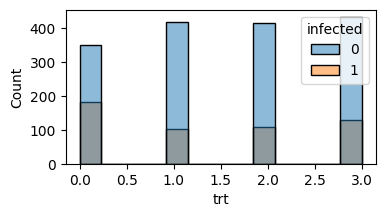

In [45]:
sns.histplot(df, x= 'trt', hue = 'infected')
plt.show()

In [46]:
df = data.copy()
df['trt0'] = (df['trt'] == 0).astype(int) # zdv only
df['trt1'] = (df['trt'] == 1).astype(int) # zdv + ddl
df['trt2'] = (df['trt'] == 2).astype(int) # zdd + zal
df['trt3'] = (df['trt'] == 3).astype(int) # ddl only

df['trtzdv'] = df['trt0'] + df['trt1'] + df['trt2']
df['trtddl'] = df['trt1'] + df['trt3']
df['trtzal'] = df['trt2'] 

#df = df.drop(columns = "treat trt trt0 trt1 trt2 trt3".split(), axis = 1)

#df = df.drop(columns = "treat trt trtzdv trtzal trtddl trt3".split(), axis = 1) #<<<< this



In [51]:
cols = "treat trt trt0 trt1 trt2 trt3 trtzdv trtzal trtddl".split()
plot_chi(df,cols)

KeyError: 'trt0'

### Str and strat

We remove str2, we keep strat, we do not dummy strat

<Axes: xlabel='strat', ylabel='Count'>

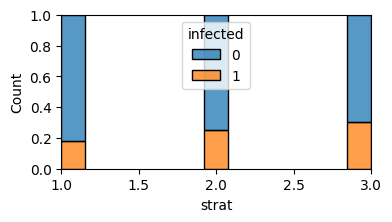

In [27]:
sns.histplot(data,x='strat',hue = "infected", multiple = 'fill')

### z30

<Axes: xlabel='preanti', ylabel='Count'>

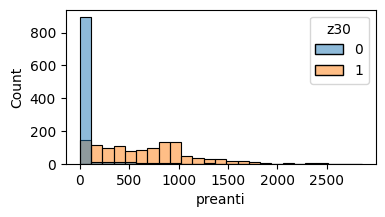

In [92]:
sns.histplot(data,x='preanti', hue = 'z30')

<Axes: xlabel='str2', ylabel='Count'>

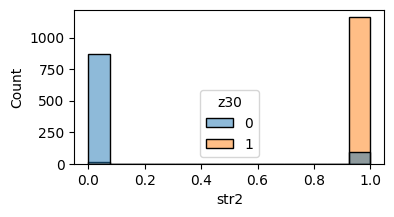

In [95]:
sns.histplot(data,x='str2', hue = 'z30')

### Symptoms



It is best to know Karnof when it is asymptomatic. If it is with symptoms then the karnofsky score does not add info. 

    feature       chi2       p-value
0    karnof  22.843439  4.353388e-05
1   symptom  34.932589  3.413199e-09
2    karsym  36.383430  2.412972e-07
3  karnosym  54.683577  3.784769e-11


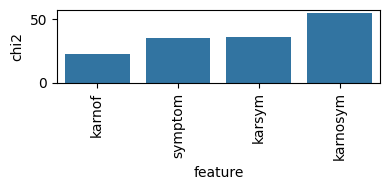

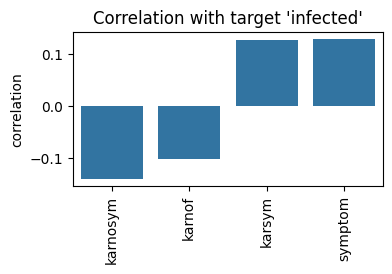

In [75]:
df = data.copy()
df['karsym'] = df['symptom']*(df['karnof'])
df['karnosym'] = (1-df['symptom'])*(df['karnof'])

plot_chi(df,"karnof symptom karsym karnosym".split())
plot_correlations(df,"karnof symptom karsym karnosym".split())


### Homo

homomale is more informative than homo

       feature      chi2   p-value
0         homo  6.037523  0.014005
1       gender  4.080192  0.043389
2     homomale  6.897491  0.008632
3   homofemale  0.689751  0.406249
4    eteromale  1.486314  0.222789
5  eterofemale  3.303812  0.069119
6     homohomo  8.027425  0.018066


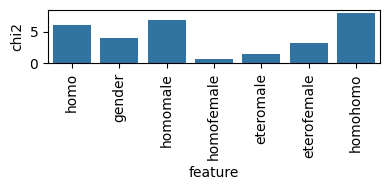

In [91]:
df = data.copy()
df['homomale'] = df['homo']*df['gender']
df['homofemale'] = df['homo']*(1-df['gender'])
df['eteromale'] = (1-df['homo'])*df['gender']
df['eterofemale'] = (1-df['homo'])*(1-df['gender'])
df['homohomo'] = (df['homo'])*(1+df['gender'])


plot_chi(df,"homo gender homomale homofemale eteromale eterofemale homohomo".split())


### cd4 vs logcd4


Not clip, log only 420

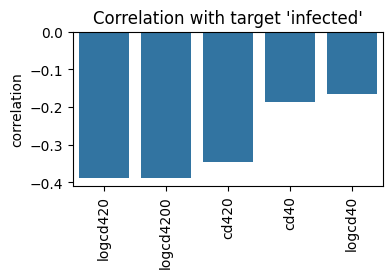

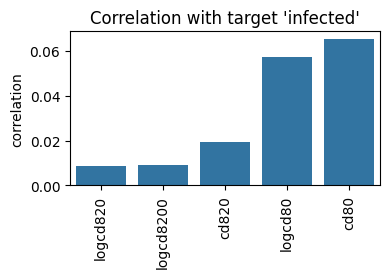

In [63]:
df = data.copy()
df['logcd40'] = np.log(df['cd40']+1)
df['logcd420'] = np.log(df['cd420']+1)
df['logcd4200'] = np.log(df['cd420']+10)

plot_correlations(df,"cd40 cd420 logcd40 logcd420 logcd4200".split())

df['logcd80'] = np.log(df['cd80']+1)
df['logcd820'] = np.log(df['cd820']+1)
df['logcd8200'] = np.log(df['cd820']+10)

plot_correlations(df,"cd80 cd820 logcd80 logcd820 logcd8200".split())

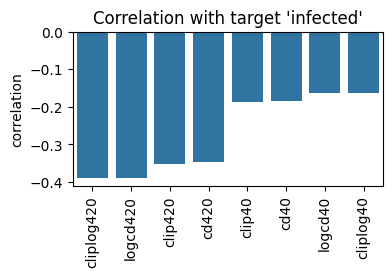

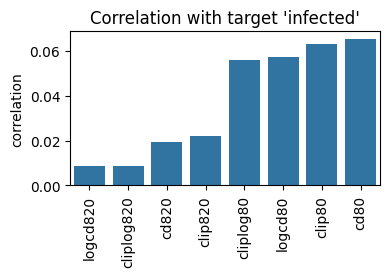

In [66]:
df['clip40'] = df['cd40'].clip(upper = 800)
df['clip420'] = df['cd420'].clip(upper = 800)
df['cliplog40'] = df['logcd40'].clip(upper = np.log(800))
df['cliplog420'] = df['logcd420'].clip(upper = np.log(800))

df['clip80'] = df['cd80'].clip(upper = 2500)
df['clip820'] = df['cd820'].clip(upper = 2500)
df['cliplog80'] = df['logcd80'].clip(upper = np.log(2500))
df['cliplog820'] = df['logcd820'].clip(upper = np.log(2500))

plot_correlations(df,"cd40 clip40 logcd40 cliplog40 cd420 clip420 logcd420 cliplog420".split())
plot_correlations(df,"cd80 clip80 logcd80 cliplog80 cd820 clip820 logcd820 cliplog820".split())

### cdratio

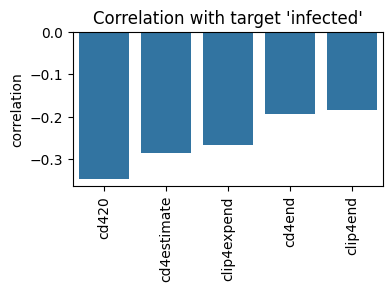

In [87]:
# replace cd40 with cd4end
df = data.copy()
df['cd4ratio'] = df['cd420']/(df['cd40']+1)
df['cd4logratio'] = np.log(df['cd4ratio'])
df['cd4logincrease'] = df['cd4logratio']*df['time']/140  # log multiplier till end
df['cd4end'] = df['cd4logratio']*df['time']/140 + np.log(df['cd40']+1) # log end
df['clip4end'] = df['cd4end'].clip(lower = 0, upper = np.log(800))
df['clip4expend'] = np.exp(df['clip4end'])

# we take the ratio, take log and multiply by time. 
t1 = df['cd40'].clip(upper = 799, lower = 1)
t2 = df['cd420'].clip(upper = 799, lower = 1)

mask0  = (t2 < 800).astype(int)
mask1  = (t1 - t2 >=  0).astype(int) * mask0
mask2  = (t1 - t2 < 0).astype(int) * mask0
mask3  = (t2 >= 800).astype(int)
# case mask1: if 420 < 40 then we exponentially decrease to zero. 
estimate1 = np.exp(np.log(t2/t1) * df['time']/140 + np.log(t1))
# case mask2: if 420 > 40 then we exponentially grow to 800. 
d1 , d2 = 800-t1, 800 - t2 # d1 > d2
estimate2  = 800 - np.exp(np.log(d2/d1) * df['time']/140 + np.log(d1))
# case mask3: if cd420>= 800 then we keep it as an estimate
estimate3 = df['cd420']
#full estimate
df['cd4estimate'] = mask1 * estimate1 + mask2 * estimate2 + mask3 * estimate3

plot_correlations(df, "cd420 cd4estimate clip4expend clip4end cd4end".split())



### Features 


In [ ]:
df = data.copy()
# drop str2
df = df.drop(columns=['str2'])
# replace cd420 with its log counterpart
df['logcd420'] = np.log(df['cd42'])
# replace cd40 with cd4end
df['cd4ratio'] = df['cd420']/(df['cd40']+1)
df['cd4logratio'] = np.log(df['cd4ratio'])
df['cd4end'] = df['cd4logratio']*df['time']/140
df = df.drop(columns=['cd40','cd420','cd4logratio','cd4ratio'])
# replace homo with homo*gender
df['homohomo'] = df['homo']*df['gender']
df = df.drop(columns=['homo'])
#df['timetime'] = np.where(df['time'] < 700, 1, 0)